# Imports & Config

In [111]:
# Data Handling
import numpy as np
import pandas as pd
# Utils
import copy
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)
# SKlearn
import sklearn as sk
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output = "default")

In [112]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers ,optimizers, metrics, losses
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [113]:
os.getcwd()

'E:\\Data Science Projects\\Kaggle - ICR - Identifying Age-Related Conditions'

In [114]:
# Notebook Config
class cfg:
    training_phase = True
    tunning_phase = True
    eda_phase = True
    submission_phase = False
    base_dir = 'E:\\Data Science Projects\\Kaggle - ICR - Identifying Age-Related Conditions'
    seed = 123

In [133]:
# Util Functions
def check_mvs(input_df):
    input_df = pd.DataFrame(input_df)
    mvs_df = pd.DataFrame(index=['#mvs','%mvs'], columns=input_df.columns)
    for i, col in enumerate(input_df.columns):
        num_mvs = input_df[col].isna().sum()
        percentage_mvs = num_mvs/input_df.shape[0]
        mvs_df[col] = [num_mvs, percentage_mvs]
    print(mvs_df.T)

def get_best_score(model_type='Tf'):
    filtered = list(filter(lambda name : name[0:2]==model_type, os.listdir('models')))
    scores = list(map((lambda name : float(name[14:-1])), filtered))
    return min(scores)

def plot_covergence(log_heads_to_plot = ['loss', 'binary_accuracy']):
    fig, axes = plt.subplots(len(log_heads_to_plot)+1,1, figsize=(8, 8))
    fig.suptitle('Checking Convergence')

    for ax, l in zip(axes[:-1], log_heads_to_plot):
        ax.plot(df_history.index+1, df_history[l], color='r', marker='.', label='Training')
        ax.plot(df_history.index+1, df_history[f'val_{l}'], color='b', marker='.', label='Validation')
        ax.set_title(l)
        ax.grid(color = 'green', linestyle = '-.', linewidth = 0.4)
        ax.legend(loc="lower right")

    axes[2].plot(df_history.index+1, df_history.lr, color='black', marker='.')
    axes[2].set_title('Learning Rate Decay')
    axes[2].grid(color = 'green', linestyle = '-.', linewidth = 0.4)

    fig.tight_layout()
    plt.show()

    
class ColumnDropper(sk.base.BaseEstimator, sk.base.TransformerMixin):
    def __init__(self, drop_col):
        #print('Initialising transformer...')
        self.drop_col = drop_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        x = copy.deepcopy(X)
        return x.drop(self.drop_col, axis=1)

# Data Handling

In [116]:
df_train = pd.read_csv(f'{cfg.base_dir}/data/train.csv')
labels = df_train.pop('Class')
df_test = pd.read_csv(f'{cfg.base_dir}/data/test.csv')
df_meta = pd.read_csv(f'{cfg.base_dir}/data/greeks.csv')

In [117]:
print(df_train.shape)

(617, 57)


In [118]:
check_mvs(df_train)

     #mvs      %mvs
Id    0.0  0.000000
AB    0.0  0.000000
AF    0.0  0.000000
AH    0.0  0.000000
AM    0.0  0.000000
AR    0.0  0.000000
AX    0.0  0.000000
AY    0.0  0.000000
AZ    0.0  0.000000
BC    0.0  0.000000
BD    0.0  0.000000
BN    0.0  0.000000
BP    0.0  0.000000
BQ   60.0  0.097245
BR    0.0  0.000000
BZ    0.0  0.000000
CB    2.0  0.003241
CC    3.0  0.004862
CD    0.0  0.000000
CF    0.0  0.000000
CH    0.0  0.000000
CL    0.0  0.000000
CR    0.0  0.000000
CS    0.0  0.000000
CU    0.0  0.000000
CW    0.0  0.000000
DA    0.0  0.000000
DE    0.0  0.000000
DF    0.0  0.000000
DH    0.0  0.000000
DI    0.0  0.000000
DL    0.0  0.000000
DN    0.0  0.000000
DU    1.0  0.001621
DV    0.0  0.000000
DY    0.0  0.000000
EB    0.0  0.000000
EE    0.0  0.000000
EG    0.0  0.000000
EH    0.0  0.000000
EJ    0.0  0.000000
EL   60.0  0.097245
EP    0.0  0.000000
EU    0.0  0.000000
FC    1.0  0.001621
FD    0.0  0.000000
FE    0.0  0.000000
FI    0.0  0.000000
FL    1.0  0.001621


## Preprocessing Pipe using SKlearn Column Transformer

In [119]:
numcols = df_train.loc[:,df_train.dtypes=='float64'].columns.to_list()

ct = ColumnTransformer([
    ('cat', OneHotEncoder(), ['EJ']),
    ('num', MinMaxScaler(), numcols)
    ])

prep_pipe = Pipeline([
    ('drop', ColumnDropper(['Id'])),
    ('ct', ct),
    ('impute', KNNImputer(n_neighbors=8))
])

prep_pipe.fit(df_train)

Pipeline(steps=[('drop', ColumnDropper(drop_col=['Id'])),
                ('ct',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['EJ']),
                                                 ('num', MinMaxScaler(),
                                                  ['AB', 'AF', 'AH', 'AM', 'AR',
                                                   'AX', 'AY', 'AZ', 'BC',
                                                   'BD ', 'BN', 'BP', 'BQ',
                                                   'BR', 'BZ', 'CB', 'CC',
                                                   'CD ', 'CF', 'CH', 'CL',
                                                   'CR', 'CS', 'CU', 'CW ',
                                                   'DA', 'DE', 'DF', 'DH', 'DI', ...])])),
                ('impute', KNNImputer(n_neighbors=8))])

## Preping data for training

In [120]:
x_tr = prep_pipe.transform(df_train)
y_tr = labels.values

if cfg.tunning_phase:
    x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.2, random_state=cfg.seed)


# Models

## Tensorflow CNN

In [121]:
# custom functions
class BalancedLogLoss(tf.keras.losses.Loss): ####fix THIIIIIIIIIIIIIIS####
    def call(self, y_true, y_pred):
        # y_true: correct labels 0, 1
        # y_pred: predicted probabilities of class=1
        # Implements the Evaluation equation with w_0 = w_1 = 1.
        # Calculate the number of observations for each class
        zero = tf.constant(1e-15)
        N_0 = tf.clip_by_value(tf.math.reduce_sum(1 - y_true), zero,1e10)
        N_1 = tf.clip_by_value(tf.math.reduce_sum(y_true), zero,1e10)
        # Calculate the predicted probabilities for each class
        p_1 = tf.clip_by_value(y_pred, zero, 1-zero)
        p_0 = tf.clip_by_value(1-p_1, zero, 1-zero)
        # Calculate the average log loss for each class
        log_loss_0 = -tf.math.reduce_sum((1 - y_true) * tf.math.log(p_0)) / N_0 
        log_loss_1 = -tf.math.reduce_sum(y_true * tf.math.log(p_1)) / N_1 
        # return the (not further weighted) average of the averages
        return (log_loss_0 + log_loss_1)/2 

class valCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if (logs.get('val_loss') < 0.1)and(logs.get('loss') < 0.1):
            print("\nstopping training!!")   
            self.model.stop_training = True

In [140]:
# model config
if cfg.tunning_phase:
    ## Conv1D
    f_conv = [(256, 5),
              (128, 5),
              (64, 5)]
    a_conv = 'relu'
    ## Dense
    u_dense = [512,
               256,
               64]
    a_dense = 'relu'
    r_dense = None #tf.keras.regularizers.L2(0.01)
    ## Compile
    initial_learning_rate = 0.001
    optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
    loss = losses.BinaryCrossentropy()
    metric = metrics.BinaryAccuracy()
    ## Fit
    batch_size = 32 #x_tr.shape[0]
    epochs = 1000
    verbose=0
    ### Callbacks
    decay = 0.0001 #initial_learning_rate/epochs
    def lr_time_based_decay(epoch, lr):
        return lr / (1 + decay * epoch)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=0)
    ES = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=20,
        verbose=0,
        mode='min',
        baseline=None,
        restore_best_weights=True)


In [141]:
# TF model
if cfg.tunning_phase:
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(57,1)))

    for f, s in f_conv:
        model.add(layers.Conv1D(f, s, activation=a_conv, padding='same'))

    model.add(layers.Flatten())

    for u in u_dense:
        model.add(layers.Dense(u, activation=a_dense, kernel_regularizer=r_dense))
        #model.add(layers.Dropout(0.3, seed=cfg.seed))


    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metric)

    model.summary()


    history = model.fit(x_tr, y_tr, 
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(x_val, y_val), 
                        callbacks=[ES, lr_decay],
                        verbose=verbose)

    df_history = pd.DataFrame(history.history)
    model.save(f'models/Tf_model(Loss={df_history.val_loss.min():.10f})', overwrite=True)

    print(f'Best epoch val_loss:{df_history.val_loss.min():.10f}')

else :
    score = get_best_score(model_type='Tf')
    model = tf.keras.models.load_model(f'{cfg.base_dir}/models/Tf_model(Loss={score:.10f})')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 57, 256)           1536      
                                                                 
 conv1d_16 (Conv1D)          (None, 57, 128)           163968    
                                                                 
 conv1d_17 (Conv1D)          (None, 57, 64)            41024     
                                                                 
 flatten_5 (Flatten)         (None, 3648)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               1868288   
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 64)               

Best epoch val_loss:0.2004748136


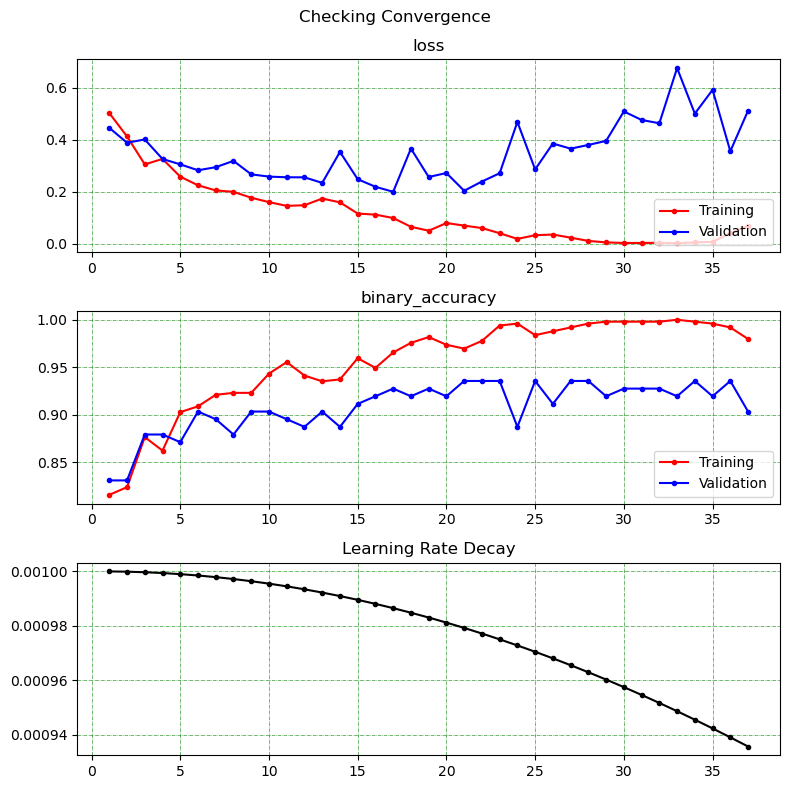

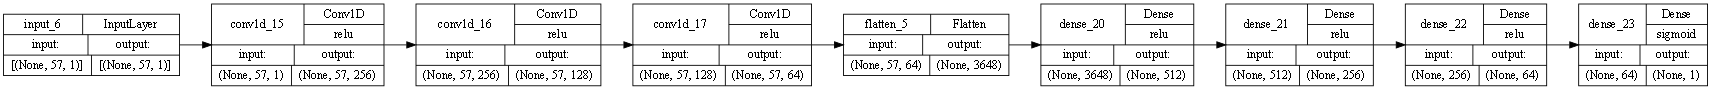

In [142]:
if cfg.tunning_phase:
    plot_covergence(['loss','binary_accuracy'])

tf.keras.utils.plot_model(
    model,
    to_file=f'models/Tf_model(Loss={df_history.val_loss.min():.10f})/Tf_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',  #TB
    expand_nested=False,
    dpi=64,
    layer_range=None,
    show_layer_activations=True)

In [106]:
tf.keras.backend.clear_session()

## Xgboost